## Измерить сечение

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [3]:
exp_tree = uproot.open('../trees/19/exp.root')['t']
mc_tree = uproot.open('../trees/19/mc.root')['t']
df_exp = preprocess.read_tree(exp_tree, mc=False)
df_mc = preprocess.read_tree(mc_tree, mc=True)

assert np.any( df_exp.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 ) #check energies in df
assert np.any( df_mc.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 )

In [5]:
# df_exp.ksalign.hist(bins=100);

____
## Fit part

In [6]:
season, nMC = 2019, 20000
energies_list = df_exp.index.unique() & df_mc.index.unique()
for i in sorted(energies_list):
    print(i, end=' ')
it = iter(energies_list)

537.5 550.0 562.5 575.0 587.5 600.0 612.5 625.0 637.5 641.0 650.0 662.5 675.0 687.5 700.0 712.5 725.0 737.5 750.0 762.0 775.0 787.5 800.0 812.5 825.0 837.5 850.0 862.5 875.0 887.5 900.0 912.5 925.0 936.0 945.0 950.0 951.1 955.0 962.5 975.0 978.0 987.5 

[$\chi^2$-calculator](https://www.di-mgt.com.au/chisquare-calculator.html)

In [7]:
fit_range = (-40, 20)
hist_range = (-40, 40)
width = fit_range[1] - fit_range[0]

params = {
    'n_sig': (1000, (0, None)),    
    'n_bkg': (  10, (0, None)),    
    'm'    : (   0, (-5, 5)),
    'sL'   : (   2, (1, 10)),
    'sR'   : (   5, (1, 10)),
    'aL'   : (   0, (0, 10)),
    'aR'   : (   0, (0, 10)),
    'k'    : ( 0.1, (0, 20)),
}

In [185]:
def get_x1(df_exp, df_mc, e0):
    dfE = df_exp.loc[e0].copy()
    dfM =  df_mc.loc[e0].copy()
    assert dfM.runnum.nunique()==1
    return dfE, dfM
    
def get_params_exp(params, m_mc, non_limited=['n_sig', 'n_bkg', 'k']):
    params_exp = params.copy()
    for k in m_mc.parameters:
        params_exp[k] = ( m_mc.values[k], params_exp[k][1] )
        if k not in non_limited:
            mean, std = m_mc.values[k], 3*m_mc.errors[k]
            params_exp[k] = ( m_mc.values[k],(mean-std, mean+std) )
    return params_exp

In [243]:
e0 = 875 #next(it)
print(f'Energy {e0} MeV')

Energy 875 MeV


In [244]:
dfE, dfM = get_x1(df_exp, df_mc, e0)
dataE, dataM = dfE.x1.values, dfM.x1.values

m_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
m_mc.simplex().migrad(iterate=20)
assert m_mc.valid

params_exp = get_params_exp(params, m_mc, ['n_sig', 'n_bkg', 'k'])
m_exp = pyfit.fitter(dataE, fit_range, params_exp, mc=False)
m_exp.simplex().migrad(iterate=20).migrad().migrad()
# assert m_exp.valid

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 85.1                       │             Nfcn = 1162              │
│ EDM = 4.13e-10 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_sig │    24     │     6     │            │            │    0    │         │       │
│ 1 │ n_bkg │    37     │     6     │            │            │    0    │         │       │
│ 2 │ m     │   -0.1    │    0.8    │            │            │-0.0584469│ 1.03991 │       │
│ 3 │ sL    │    2.4    │    0.6    │            │            │ 2.07626 │ 2.86389 │       │
│ 4 │ sR    │    1.3    │    0.8    │            │            │ 1.33069 │ 2.44535 │       │
│ 5 │ aL    │   0.064   │   0.012   │            │            │0.0642588│0.0861058│       │
│ 6 │ aR    │   0.25    │   0.05    │            │            │0.245803 │0.301585 │       │
│ 7 │ k     │   0.12    │   0.12    │            │            │    0    │   20    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────────────┐
│       │     n_sig     n_bkg         m        sL        sR        aL        aR         k │
├───────┼─────────────────────────────────────────────────────────────────────────────────┤
│ n_sig │      32.1     -20.3  4.92e-09     0.358   7.8e-10 -3.64e-07 -5.04e-09    -0.241 │
│ n_bkg │     -20.3        39 -9.41e-10    -0.356  6.64e-10  4.77e-07  5.07e-09     0.241 │
│     m │  4.92e-09 -9.41e-10  3.99e-12  6.46e-09  6.65e-16     2e-14 -4.51e-17  1.18e-10 │
│    sL │     0.358    -0.356  6.46e-09     0.383   5.6e-10  8.33e-08 -3.73e-10   0.00255 │
│    sR │   7.8e-10  6.64e-10  6.65e-16   5.6e-10  8.65e-14  1.68e-14  -1.7e-21  8.18e-12 │
│    aL │ -3.64e-07  4.77e-07     2e-14  8.33e-08  1.68e-14  1.51e-10  -3.9e-15  5.85e-10 │
│    aR │ -5.04e-09  5.07e-09 -4.51e-17 -3.73e-10  -1.7e-21  -3.9e-15     7e-14  9.08e-11 │
│     k │    -0.241     0.241  1.18e-10   0.00255  8.18e-12  5.85e-10  9.08e-11    0.0156 │
└───────┴─────────────────────────────────────────────────────────────────────────────────┘

,n_sig_exp,n_bkg_exp,n_sig_mc
987.5,32.428316,67.586926,1152.002206
650.0,115.328843,2.671179,1348.081553
775.0,135.257916,13.742119,2915.978769
837.5,127.517038,42.483028,3470.890091
875.0,23.617363,37.382644,1285.960306


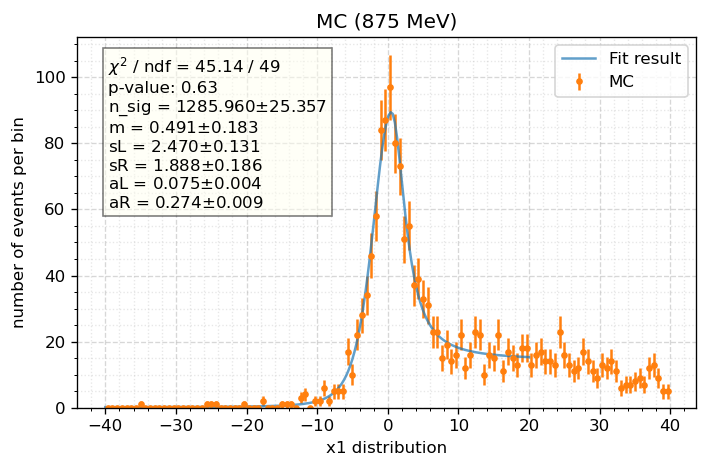

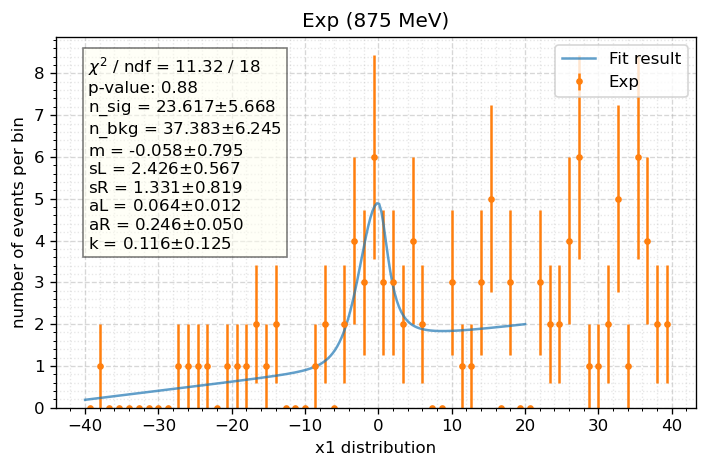

In [245]:
#Plot and save data

pys.plot_fit(dataM, pyfit.sig_pdf, m_mc, 120, hist_range, fit_range, errors=True, label='MC', xtitle='x1 distribution',
           ytitle='number of events per bin', title=f'MC ({e0} MeV)', description=True)
# plt.savefig(f'images/fit11/mc_{e0}.png', dpi=120)

pys.plot_fit(dataE, pyfit.pdf, m_exp, 60, hist_range, fit_range, errors=True, label='Exp', xtitle='x1 distribution',
           ytitle='number of events per bin', title=f'Exp ({e0} MeV)', description=True)
# plt.savefig(f'images/fit11/exp_{e0}.png', dpi=120)

if 'res_df' not in locals():
    def add_postfix(arr, post):
        return [f'{_}_{post}' for _ in arr]
    cols = add_postfix(m_exp.parameters, 'exp') + add_postfix(m_exp.parameters, 'exp_err') + \
        add_postfix(m_mc.parameters, 'mc') + add_postfix(m_mc.parameters, 'mc_err') + ['emeas']
    res_df = pd.DataFrame(columns=cols)
    del cols
temp_ser = pd.Series(list(m_exp.values) + list(m_exp.errors) + 
                     list(m_mc.values) + list(m_mc.errors) + [dfE.emeas.mean()], index=res_df.columns, name=e0)
if temp_ser.name in res_df.index:
    res_df.drop(temp_ser.name, axis=0, inplace=True)
res_df = res_df.append(temp_ser)
del temp_ser

res_df[['n_sig_exp', 'n_bkg_exp', 'n_sig_mc']].tail()

Распределения

In [248]:
# res_df.to_csv('./images/fit19_new.csv')

In [247]:
res_df[['n_sig_exp', 'n_sig_exp_err']]

,n_sig_exp,n_sig_exp_err
537.5,2178.978308,32.874884
550.0,1524.769472,34.786473
562.5,723.817921,22.669801
575.0,573.013736,15.933425
587.5,401.965750,21.119477
600.0,296.434204,15.183261
612.5,187.720811,12.213822
625.0,216.823545,13.612419
637.5,136.266963,9.883780
641.0,913.335056,23.993618


In [10]:
e0 = next(it)
print(f'Energy {e0} MeV')

dfE = df_exp.loc[e0].copy()
dfM =  df_mc.loc[e0].copy()
assert dfM.runnum.nunique()==1

phi =  0.205/(e0*2e-3-0.732) + 0.14

# x1, x2 = get_x(dfE, phi)
# dfE = dfE.assign(x1=x1, x2=x2)
# x1, x2 = get_x(dfM, phi)
# dfM = dfM.assign(x1=x1, x2=x2)

Energy 525.0 MeV


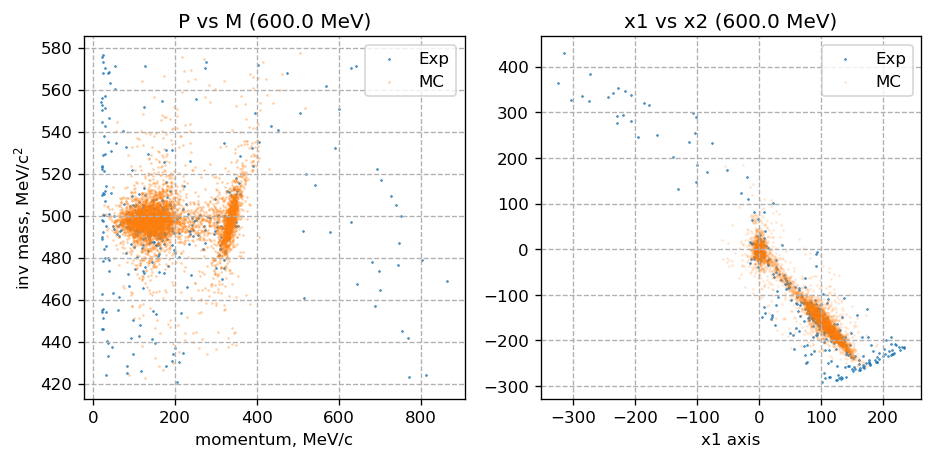

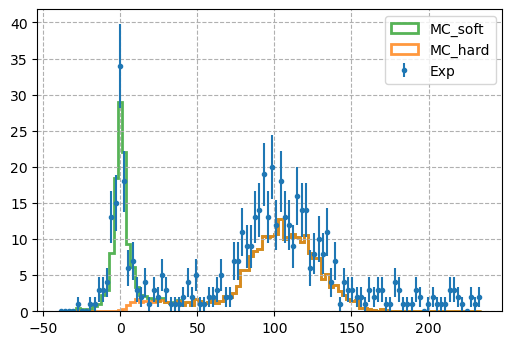

In [62]:
plot_mp_scatters(dfE, dfM, e0)
# dfM.sim_energy.hist(figsize=(4,2))
plot_x1_profile(dfM, dfE, sim_energy_cut=0.015)

Write

In [666]:
if 'res_df' not in locals():
    def add_postfix(arr, post):
        return [f'{_}_{post}' for _ in arr]
    cols = add_postfix(md.values.keys(), 'mc') + add_postfix(md.errors.keys(), 'mc_err') + \
        add_postfix(md2.values.keys(), 'exp') + add_postfix(md2.errors.keys(), 'exp_err') + ['emeas']
    res_df = pd.DataFrame(columns=cols)
    del cols

In [667]:
temp_ser = pd.Series(md.values.values() + md.errors.values() + md2.values.values() + md2.errors.values() + [dfE.emeas.mean()], index=res_df.columns, name=e0)
res_df = res_df.append(temp_ser)
del temp_ser

In [752]:
res_df.tail()

,n_sig_exp,n_bkg_exp,m_exp,sL_exp,sR_exp,aL_exp,aR_exp,k_exp,n_sig_exp_err,n_bkg_exp_err,...,sR_mc,aL_mc,aR_mc,n_sig_mc_err,m_mc_err,sL_mc_err,sR_mc_err,aL_mc_err,aR_mc_err,emeas
737.5,25.048009,53.949529,2.685768,2.844481,1.690998,0.093780,0.123254,7.679276e-03,5.270123,6.498215,...,1.920735,0.088575,0.132469,28.373002,0.134503,0.102720,0.114869,0.002602,0.004607,735.729675
750.0,60.177652,36.791486,0.114280,2.785102,2.188917,0.074652,0.134003,8.431145e-10,6.863252,5.948565,...,2.460104,0.080015,0.127490,31.573184,0.151295,0.110742,0.135594,0.002681,0.005177,747.056946
762.5,65.979029,14.052139,1.264207,2.192900,2.211926,0.091689,0.106906,1.771536e+01,1.365746,1.319680,...,2.418338,0.087418,0.114873,35.892034,0.108005,0.080319,0.103206,0.002136,0.003983,761.185852
775.0,84.310870,16.689099,0.095402,2.957448,2.832905,0.085313,0.125526,2.110758e-01,7.973018,5.427885,...,2.623367,0.080844,0.117161,37.866441,0.116522,0.087508,0.104769,0.002235,0.004183,771.605164
1000.0,4.213653,27.788314,0.389503,2.225870,2.320756,0.094478,0.108607,1.134011e-02,1.165728,1.281508,...,2.605904,0.099734,0.119660,26.760781,0.149410,0.104054,0.142623,0.002628,0.005526,785.936523


In [750]:
# res_df = res_df.drop_duplicates(subset=['emeas'], keep='last')

In [751]:
# res_df.to_csv('images/fit11_new.csv')

Triggers

In [173]:
df_exp

,runnum,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],trho[0],...,ksminv,ksptot,ksalign,kslen,ksdpsi,kspipt[0],kspipt[1],x1,x2,ksangle
ebeam,,,,,,,,,,,,,,,,,,,,,
537.5,70914,537.454102,1,1.467840,2.093872,1.175148,0.572584,225.439392,200.295303,-0.453414,...,495.398590,127.203461,0.991149,0.692653,2.549026,226.311050,202.064529,49.427895,-57.641896,0.133149
537.5,70914,537.454102,1,2.027570,0.925644,3.104403,1.923712,232.232147,204.302963,-0.206040,...,501.869080,110.060333,0.999977,0.273585,2.641230,229.413345,201.676880,65.747489,-65.974056,0.006836
537.5,70914,537.454102,3,2.160736,0.950152,1.819007,1.575463,270.602844,158.558121,0.366706,...,498.581360,129.305893,0.997950,1.188962,2.829283,270.280334,158.092651,50.368658,-53.945248,0.064037
537.5,70915,537.454102,3,1.425534,2.139219,-0.976147,-1.563741,304.971161,143.951935,-0.267683,...,496.262360,203.401581,0.999431,1.175832,2.537743,305.043518,144.463287,-1.190086,-0.679456,0.033721
537.5,70915,537.454102,1,1.341840,2.135383,-1.462752,-1.678701,190.909622,257.435211,-0.873182,...,502.171967,174.709442,0.996199,1.045580,2.403119,191.558563,259.535583,22.483307,-17.934390,0.087217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987.5,81772,987.804626,3,1.166559,1.116872,2.075167,1.794971,126.393555,552.197937,-0.497010,...,497.953094,570.329956,0.999996,0.579546,1.533195,126.441803,551.404419,85.273864,-269.835015,0.002970
987.5,81772,987.804626,3,0.859478,1.075907,-19.348133,-18.753222,262.856812,391.176636,1.764664,...,500.777130,507.659851,0.958074,3.103970,1.397760,262.459412,391.704407,106.777701,-328.768046,0.290593
987.5,81772,987.804626,3,1.446577,1.645980,2.467281,2.775065,135.940979,364.992645,-0.863671,...,491.026123,318.573120,0.997844,0.866976,2.099769,135.852036,364.755066,154.229369,-512.063472,0.065684


In [174]:
trig_df = pd.DataFrame()
for ee in energies_list:
    dfE = df_exp.loc[ee].copy()
    dfM = df_mc.loc[ee].copy()
#     print(ee)
    assert dfM.runnum.nunique()==1
    xmin, xmax = fit_range
    dfE = dfE.query('x1<@xmax&x1>@xmin')[['trigbits']]
    dfE[ee] = 1
    trig_df = trig_df.append(pd.pivot_table(dfE, values=ee, columns='trigbits', aggfunc='sum'))
trig_df = trig_df.fillna(0).drop(0, axis=1).rename({1: 'TF', 2: 'CF', 3:'TC'}, axis=1)

In [175]:
t, c, tc = trig_df['TF'] + trig_df['TC'], trig_df['CF'] + trig_df['TC'], trig_df['TC']

trig_df['effT'] = (tc + 1)/(c + 2)
trig_df['effC'] = (tc + 1)/(t + 2)

trig_df['effT_err'] = np.sqrt( (tc+1)*(tc+2)/(c+2)/(c+3) - ((tc+1)/(c+2))**2 )
trig_df['effC_err'] = np.sqrt( (tc+1)*(tc+2)/(t+2)/(t+3) - ((tc+1)/(t+2))**2 )

trig_df['eff_trig']  = 1 - (1-trig_df.effT)*(1-trig_df.effC)
trig_df['eff_trig_err']  = np.sqrt( (trig_df.effT_err*(1-trig_df.effC))**2 
                             + (trig_df.effC_err*(1-trig_df.effT))**2 )

In [177]:
# trig_df.to_csv('images/triggers19_new.csv')

Если не фиксировать параметры в экспериментальном распределении, то провожу статистический тест.

Гипотеза $H_0$ - параметры распределений в эксперименте и моделировании одинаковы

Проверяем гипотезу на уровне значимости 5% = $2 \cdot \sigma$

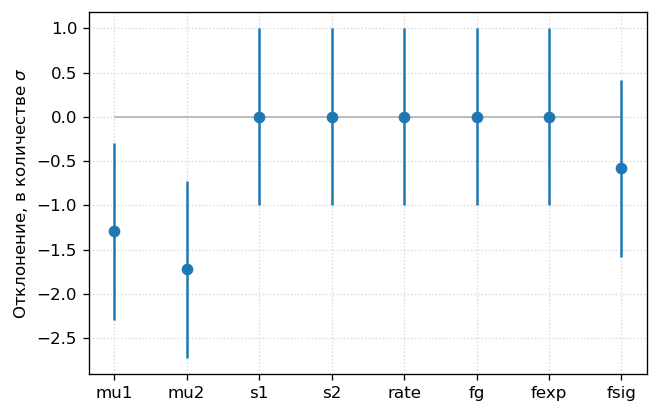

In [639]:
valsE, errsE = m_exp.values, m_exp.errors
valsM, errsM = m_mc.values, m_mc.errors
x0, ex = [], []
var =  ['mu1', 'mu2', 's1', 's2', 'rate', 'fg', 'fexp', 'fsig']
for k in var:
    error = (np.sqrt(errsE[k]**2 + errsM[k]**2))
    x0.append((valsE[k] - valsM[k])/error)
    
plt.hlines(y=0, xmin=0, xmax=len(x0)-1, zorder=-1, color='k', lw=1, alpha=0.3)
plt.errorbar(range(len(x0)), x0, yerr=1, fmt='o')
plt.grid(ls=':', alpha=0.5)
plt.ylabel('Отклонение, в количестве $\\sigma$')
plt.xticks(range(len(x0)), var);
# del valsE, valsM, errsE, errsM

In [484]:
from pylib.radcors import RadCor

In [485]:
cs_approx = pd.read_csv('../data/cross_sections_kskl.txt', header=None, sep=' ')[[1, 2]]
cs_approx[1] /= 2

In [486]:
cs_approx

,1,2
0,497.5,0.000000
1,498.0,0.067593
2,498.5,0.292279
3,499.0,0.642567
4,499.5,1.128050
...,...,...
550,1046.0,0.368000
551,1047.0,0.381000
552,1048.0,0.394000
553,1049.0,0.409000


In [77]:
r = RadCor(cs_approx[1], cs_approx[2])

In [78]:
r.F_Radcor(1059.947/2)

(1.8978407634915915, 1.3592433366270849e-05)

In [44]:
np.extract(r.y>1000, r.y)

array([1009.83788297, 1042.80429893, 1074.80668805, 1105.84505034,
       1135.91938579, 1165.02969441, 1193.1759762 , 1220.35823115,
       1246.57645926, 1271.10635807, 1291.33171835, 1307.01606621,
       1318.15940165, 1324.76172467, 1326.82303528, 1324.34333347,
       1317.32261923, 1305.76089258, 1289.65815351, 1269.01440203,
       1243.82963812, 1214.10386179, 1179.83707305, 1141.02927189,
       1097.68045831, 1049.79063231])

In [45]:
np.extract(r.y>1000, r.x)

array([509.02958296, 509.08582858, 509.14207421, 509.19831983,
       509.25456546, 509.31081108, 509.36705671, 509.42330233,
       509.47954795, 509.53579358, 509.5920392 , 509.64828483,
       509.70453045, 509.76077608, 509.8170217 , 509.87326733,
       509.92951295, 509.98575858, 510.0420042 , 510.09824982,
       510.15449545, 510.21074107, 510.2669867 , 510.32323232,
       510.37947795, 510.43572357])

In [10]:
# dfExp = uproot.open('../trees/exp2019.root')['t'].pandas.df()
dfMC  = uproot.open('../trees/19/mc_mcgpj.root')['t'].pandas.df()

In [8]:
dfExp = uproot.open('../trees/exp2019_runs.root')['t'].pandas.df()


In [11]:
dfMC

,ebeam,runnum,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],...,tchi2r[1],tchi2z[0],tchi2z[1],tnhit[0],tnhit[1],ksminv,ksptot,ksalign,kslen,name
entry,,,,,,,,,,,,,,,,,,,,,
0,537.453979,0,537.453979,1,2.005805,0.816097,0.241445,-0.888369,143.569092,311.319489,...,1.170788,0.991979,0.694018,20,9,499.395172,216.374481,0.999027,2.772172,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
1,537.453979,0,537.453979,1,2.100847,1.231824,0.373388,1.236971,163.939804,266.816101,...,0.386262,0.529379,2.069548,20,13,505.448303,115.481873,0.993188,1.221455,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
2,537.453979,0,537.453979,3,1.064023,2.009341,0.545712,0.701725,207.671967,250.174591,...,1.026735,0.957598,2.091434,21,16,497.253052,201.719330,0.996737,0.513309,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
3,537.453979,0,537.453979,3,1.970497,1.382862,-1.777212,-1.631636,237.645996,216.820862,...,0.688015,1.209268,1.051637,16,17,497.766693,194.066284,0.999999,0.949363,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
4,537.453979,0,537.453979,1,2.077082,0.747478,-3.668395,-3.670606,234.502472,192.621414,...,0.258133,0.670550,1.641627,15,11,496.693756,116.323097,0.992242,0.680561,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180964,987.804504,0,987.804504,0,2.296050,2.302264,-3.326244,-2.858969,217.647888,326.898590,...,1.985037,0.435221,0.937301,8,9,488.565735,378.995667,0.985185,2.075993,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
180965,987.804504,0,987.804504,2,1.565175,2.376279,3.020628,4.328830,392.622803,558.588196,...,0.396961,0.814028,2.583056,18,13,502.476227,851.478271,0.999599,0.804988,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
180966,987.804504,0,987.804504,3,1.524234,1.348975,4.602494,5.106483,106.665916,370.123230,...,0.786073,0.843128,0.852886,22,17,425.076477,383.258636,0.935170,0.304142,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
